In [1]:
from keras.models import Model
import keras.models
import keras.layers as layers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from keras import backend as K
from keras_contrib.layers.normalization import InstanceNormalization

import argparse
import cnn_analyzer as cnna
import cnn_builder as cbuild
import cnn_runner as crun
import config
import csv
import niftiutils.helper_fxns as hf
import importlib
import itertools
from math import sqrt, log, pi, exp
import matplotlib.pyplot as plt
from numba import jit, njit, prange, vectorize, guvectorize
import numpy as np
import operator
import os
import pandas as pd
import random
import scipy
import time
%matplotlib inline

C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
importlib.reload(config)
importlib.reload(hf)
importlib.reload(cbuild)
importlib.reload(crun)
C = config.Config()
T = config.Hyperparams()
#T.steps_per_epoch = 50
#T.epochs= 1
#T.get_best_hyperparams()

In [ ]:
crun.run_fixed_hyperparams([C], hyperparams=T)#C_list)

In [ ]:
model = cbuild.build_cnn_hyperparams(T)
model.summary(line_length=150)

In [68]:
Z_reader = ['E103312835_1','12823036_0','12569915_0','E102093118_0','E102782525_0','12799652_0','E100894274_0','12874178_3','E100314676_0','12842070_0','13092836_2','12239783_0','12783467_0','13092966_0','E100962970_0','E100183257_1','E102634440_0','E106182827_0','12582632_0','E100121654_0','E100407633_0','E105310461_0','12788616_0','E101225606_0','12678910_1','E101083458_1','12324408_0','13031955_0','E101415263_0','E103192914_0','12888679_2','E106096969_0','E100192709_1','13112385_1','E100718398_0','12207268_0','E105244287_0','E102095465_0','E102613189_0','12961059_0','11907521_0','E105311123_0','12552705_0','E100610622_0','12975280_0','E105918926_0','E103020139_1','E101069048_1','E105427046_0','13028374_0','E100262351_0','12302576_0','12451831_0','E102929168_0','E100383453_0','E105344747_0','12569826_0','E100168661_0','12530153_0','E104697262_0']
X_test, Y_test, train_generator, num_samples, train_orig, Z = cbuild.get_cnn_data(n=4, n_art=0)#, Z_test_fixed=Z_reader)
Z_test, Z_train_orig = Z
X_train_orig, Y_train_orig = train_orig

In [59]:
#from keras.utils import multi_gpu_model
#model = multi_gpu_model(model, gpus=2)

In [ ]:
hist = model.fit_generator(train_generator, steps_per_epoch=T.steps_per_epoch, epochs=T.epochs, validation_data=[X_test, Y_test])#, callbacks=[T.early_stopping])

In [71]:
model.save('E:\\models\\model_reader_rcnn.hdf5')

In [23]:
import dr_methods as drm
voi_df_art, voi_df_ven, voi_df_eq = drm.get_voi_dfs()
small_voi_df = pd.read_csv(C.small_voi_path)

In [ ]:
#plot_with_bbox(fn_list[2], cls_mapping[wrong_guesses[2]])
Y_pred = model.predict(X_test)
y_true = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_test])
y_pred = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_pred])

cm = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="weighted")

#save_output(Z_test, y_pred, y_true)

print(accuracy_score(y_true, y_pred))
#y_true_simp, y_pred_simp, _ = cnna.merge_classes(y_true, y_pred)
#print(accuracy_score(y_true_simp, y_pred_simp))

In [3]:
model = keras.models.load_model(os.path.join(C.model_dir, "models_305.hdf5")) #models_305

In [344]:
importlib.reload(cbuild)

<module 'cnn_builder' from 'C:\\Users\\Clinton\\Documents\\voi-classifier\\python\\cnn_builder.py'>

In [312]:
X_test, Y_test, train_generator, num_samples, train_orig, Z = cbuild.get_cnn_data(n=4, n_art=0, Z_test=Z_reader)
Z_test, Z_train_orig = Z
Y_pred = model.predict(X_test)
y_true = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_test])
y_pred = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_pred])
y_true_simp, y_pred_simp, _ = cbuild.merge_classes(y_true, y_pred)

In [42]:
Y_pred = [C.classes_to_include[y] for y in y_pred]
Y_true = [C.classes_to_include[y] for y in y_true]

In [43]:
a = pd.DataFrame([Z_test,Y_pred,Y_true])

In [45]:
a.to_csv('E:\\temp.csv')

In [205]:
acc6cls = []
acc3cls = []

for i in range(19):
    model_num = 306+i
    X_test, Y_test, train_generator, num_samples, train_orig, Z = cbuild.get_cnn_data(n=4, n_art=0, Z_test=df[df['model_num'] == model_num]["z_test"])
    X_train_orig, Y_train_orig = train_orig
    model = keras.models.load_model(os.path.join(C.model_dir, "models_%d.hdf5" % model_num)) #models_305
    
    Y_pred = model.predict(X_train_orig)
    y_true = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_train_orig])
    y_pred = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_pred])

    acc6cls.append(accuracy_score(y_true, y_pred))

    y_true_simp, y_pred_simp, _ = cbuild.merge_classes(y_true, y_pred)

    acc3cls.append(accuracy_score(y_true_simp, y_pred_simp))

In [22]:
df = pd.read_excel("Z:\\Inter-reader study\\Answer key.xlsx")

In [23]:
y_true = df["Class"].values
y_pred = df["Model"].values

In [24]:
cm = confusion_matrix(y_true, y_pred, labels=C.classes_to_include)

In [46]:
for i in range(len(cm)):
    print('\t'.join(cm[:,i].astype(str)))

10	0	1	0	0	1
0	9	1	0	0	0
0	1	8	0	0	0
0	0	0	10	0	0
0	0	0	0	9	0
0	0	0	0	1	9


In [72]:
fn_list = fn_list + list(Z_test[~np.equal(y_pred, y_true)])

In [74]:
fn_list = fn_list + list(Z_train_orig[~np.equal(y_pred, y_true)])
fn_list = fn_list + list(Z_train_orig[~np.equal(y_pred, y_true)])

In [75]:
fn_x_list = [x+"("+str(voi_df_art[voi_df_art["id"] == x[:-4]]["x1"].values[0])+")" for x in fn_list]

In [76]:
unique, counts = np.unique(fn_x_list, return_counts=True)

In [ ]:
dict(zip(unique, counts))

In [195]:
Y_pred = model.predict(X_train_orig)
y_true = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_train_orig])
y_pred = np.array([max(enumerate(x), key=operator.itemgetter(1))[0] for x in Y_pred])

cm = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="weighted")

#cbuild.save_output(Z_train_orig, y_pred, y_true)#, save_dir=C.output_img_dir+"\\training")

In [6]:
importlib.reload(cbuild)

<module 'cnn_builder' from 'C:\\Users\\Clinton\\Documents\\voi-classifier\\python\\cnn_builder.py'>

In [3]:
model = keras.models.load_model(os.path.join(C.model_dir, "models_305.hdf5")) #models_305
#cnna.visualize_layer(model, 'conv3d_148')

In [4]:
model_dense_outputs = cbuild.build_pretrain_model(model)

In [ ]:
model_dropout = cbuild.build_model_forced_dropout(model, )

In [5]:
orig_data_dict, num_samples = cbuild._collect_unaug_data()

In [7]:
filters_by_cls = {cls: model_dense_outputs.predict(orig_data_dict[cls][0], verbose=False) for cls in C.classes_to_include}
fig = cnna.tsne(filters_by_cls)
fig.show()

In [224]:
len(hf.flatten([list(feature_sheet["evidence1"+cls].dropna().values) for cls in C.classes_to_include]))

137

In [8]:
importlib.reload(config)
C=config.Config()

In [6]:
filters_by_cls = {cls: model_dense_outputs.predict(orig_data_dict[cls][0], verbose=False) for cls in C.classes_to_include}
filter_results = np.concatenate([filters_by_cls[cls] for cls in C.classes_to_include], axis=0)

filter_avgs = np.mean(filter_results, axis=0)
filter_stds = np.std(filter_results, axis=0)

#filter_cls_avg_unscaled = {cls: np.mean(filter_results[cls], axis=0) for cls in C.classes_to_include}
#filter_cls_avg_scaled = {cls: np.mean(filter_results[cls], axis=0) / filter_avgs for cls in C.classes_to_include}

features_by_cls, feat_count = cnna.collect_features()
all_features = list(feat_count.keys())
cls_features = {f: [c for c in C.classes_to_include if f in features_by_cls[c]] for f in all_features}

z = dict(zip(*np.unique(features_by_cls['colorectal'], return_counts=True)))
for k in z:
    print(k, " (",z[k],")", sep="")

In [ ]:
feat_count

In [7]:
Z_features = cnna.get_annotated_files(features_by_cls)

In [8]:
feature_filter_means = {}
feature_filter_stds = {}
feature_filters_scaled = {}#{cls: {} for cls in features}
feature_filters = {f:np.empty([0,100]) for f in all_features}

for f in all_features:
    for cls in C.classes_to_include:
        x_features = orig_data_dict[cls][0][np.where(np.isin(orig_data_dict[cls][1], Z_features[f]))]
        if x_features.size > 0:
            feature_filters[f] = np.concatenate([feature_filters[f], model_dense_outputs.predict(x_features, verbose=False)], axis=0)# / filter_avgs
        
    feature_filters[f] = (feature_filters[f] - filter_avgs) / filter_stds
    
    feature_filter_means[f] = np.mean(feature_filters[f], axis=0)# / filter_avgs
    feature_filter_stds[f] = np.std(feature_filters[f], axis=0)# / filter_avgs

    #ff = feature_filters[f]
    #feature_filters[f] = np.where(ff > np.mean(ff), ff, 0)

    #ff = feature_filters[cls][f]
    #feature_filters[cls][f] = np.where(ff > 1*filter_cls_avg_unscaled[cls], ff, 0)

    #ff = feature_filters[f]
    #feature_filters[f] = np.where(ff > 1.3*filter_avgs, ff, 0)

    feature_filters_scaled[f] = feature_filter_means[f] / filter_avgs

In [9]:
num_features = len(all_features) # number of features
num_units = 100 # number of dense units

In [ ]:
num_annotations = 5
Z_test = ['E106097391_0', 'E104978772_1', '12900535_0', 'E100150242_0', 'E105490014_0', 'E103147618_0', 'E103510187_0', 'E104657225_0', 'E100551966_0', 'E101388602_0', 'E100215900_8', 'E100215900_7', 'E104045692_0', '13104521_0', 'E100383453_0', '12943286_0', '12271995_0', 'E102315724_0', 'E104949189_0', 'E100511083_1', 'E101579471_0', '13018986_1', '13203550_8', '13112385_0', '12712463_0', '12361082_0', '13028374_0', 'E103985934_1', 'E100529980_0', '12042703_3', '12961059_0', 'E105724706_2', 'E100592424_2', 'E103104254_0', 'E104546069_0', 'E101665217_1', '12090000_0', 'E100592424_1', '12961059_1', 'E105474285_0', '12502068_1', 'E100814791_0', 'E102613189_0', 'E105427046_0', 'E102881031_1', 'E102929168_0', 'E102310482_0', 'E102095465_0', 'E101811299_0', 'E104737273_0', '12890053_0', 'E100168661_1', '12637865_0', 'E100168661_2', '12239783_0', '12707781_0', '12706568_1', '12823036_0', '12404081_0', '12365693_1']

indices_f = [orig_data_dict[cls][1] for cls in C.classes_to_include]
indices_f = hf.flatten(indices_f)

fixed_indices = np.empty([num_features, num_annotations])
for f_ix,f in enumerate(all_features):
    print(f)
    fixed_indices[f_ix, :] = np.where(np.isin(indices_f, random.sample(set(Z_features[f]), num_annotations)))[0]
fixed_indices = fixed_indices.astype(int)

test_indices = np.where(np.isin(indices_f, Z_test))[0]

In [18]:
mu = np.empty([num_features, num_units])
sigma = np.empty([num_features, num_units])
m = filter_avgs#np.empty(n) #dense unit mean without features
s = filter_stds#np.empty(n) #dense unit stdev without features

In [19]:
theta_11 = scipy.random.uniform(.2,.3, size=[num_features, num_features])
theta_10 = scipy.random.uniform(.2,.3, size=[num_features, num_features])
theta_01 = scipy.random.uniform(.2,.3, size=[num_features, num_features])

In [20]:
for i in range(num_features):
    mu[i] = feature_filter_means[all_features[i]]
    sigma[i] = feature_filter_stds[all_features[i]]

In [21]:
z_states = np.array([z for z in itertools.product([0,1], repeat=num_features) if sum(z) <= 4 and sum(z) >= 2])
num_states = len(z_states)
num_imgs = filter_results.shape[0]
z_states_bool = [tuple([bool(x) for x in z]) for z in z_states]

In [22]:
p_z_x = np.empty([num_imgs, num_states])
p_x_z = np.empty([num_imgs, num_states])
p_x = np.empty(num_imgs)
Z = np.empty(num_imgs)

eps = 10**-300

In [359]:
t=time.time()
for _ in range(num_states*10):
    np.nan_to_num(0)
    #pass
print(time.time()-t)

0.02306342124938965


In [13]:
from numba import float64

@guvectorize([(float64[:], float64, float64[:], float64, float64, float64[:], float64)], '(n),(),(n),(),(),(n)->(n)')
def get_p_x_z(mu, m, sigma, s, x, z, res):
    mean = np.dot(mu, z) + m
    stdev = sqrt(np.dot(sigma**2, z) + s**2)
    #stdev = sqrt(np.sum(np.where(z==1, sigma[:, u_ix]**2, 0)) + s[u_ix]**2)

    res = 1/stdev * exp(-((x-mean)/stdev)**2/2)

In [25]:
img_ix = 531

In [33]:
num_states

1925

In [32]:
len(state_ixs)

469

In [79]:
@njit
def get_all_p_x_z(mu, m, sigma, s, z_states, filter_results):
    num_imgs = filter_results.shape[0]
    num_states = len(z_states)
    num_units = m.shape[0]
    
    tmp = np.empty(num_units)
    p_x_z = np.zeros((num_imgs, num_states))
    
    for img_ix in range(num_imgs):
        for state_ix in range(num_states):
            z = np.array([float(z) for z in z_states[state_ix]])

            for u_ix in range(num_units):
                mean = np.dot(mu[:, u_ix], z) + m[u_ix]
                stdev = sqrt(np.dot(sigma[:, u_ix]**2, z) + s[u_ix]**2)
                #stdev = sqrt(np.sum(np.where(z==1, sigma[:, u_ix]**2, 0)) + s[u_ix]**2)

                #tmp[u_ix] = get_p_x_z(mu[:, u_ix], m[u_ix], sigma[:, u_ix], s[u_ix], filter_results[img_ix, u_ix], z)
                tmp[u_ix] = 1/stdev * exp(-((filter_results[img_ix, u_ix]-mean)/stdev)**2/2)

            #p_x_z[img_ix, state_ix] = get_p_x_z(mu, m, sigma, s, filter_results[img_ix], z)
            p_x_z[img_ix, state_ix] = tmp.prod()
    
    return p_x_z

@njit
def get_all_p_z_x(p_x_z, Z, p_z):
    p_z_x = np.empty(p_x_z.shape)
    for img_ix in range(p_x_z.shape[0]):
        for state_ix in range(p_x_z.shape[1]):
            p_z_x[img_ix, state_ix] = p_x_z[img_ix, state_ix] * p_z[state_ix] / Z[img_ix]
    return p_z_x

@njit
def update_thetas(p_z_x_sum, z_states_bool):
    num_states = len(z_states_bool)
    num_features = len(z_states_bool[0])
    theta_11 = np.empty((num_features, num_features))
    theta_10 = np.empty((num_features, num_features))
    theta_01 = np.empty((num_features, num_features))
    
    for a in range(num_features):
        for b in range(num_features):
            num11 = 0
            den11 = eps
            num10 = 0
            den10 = eps
            num01 = 0
            den01 = eps
            for state_ix in range(num_states):
                z = z_states_bool[state_ix]
                num11 += p_z_x_sum[state_ix] * z[a]*z[b] * (1 - theta_10[a,b] - theta_01[a,b])
                den11 += p_z_x_sum[state_ix] * (z[a]*z[b] + (not z[a] and not z[b]))
                num10 += p_z_x_sum[state_ix] * (z[a] and not z[b]) * (1 - theta_11[a,b] - theta_01[a,b])
                den10 += p_z_x_sum[state_ix] * ((z[a] and not z[b]) + (not z[a] and not z[b]))
                num01 += p_z_x_sum[state_ix] * (not z[a] and z[b]) * (1 - theta_11[a,b] - theta_10[a,b])
                den01 += p_z_x_sum[state_ix] * ((not z[a] and z[b]) + (not z[a] and not z[b]))

            theta_11[a,b] = num11 / den11
            theta_10[a,b] = num10 / den10
            theta_01[a,b] = num01 / den01
            
    return theta_11, theta_10, theta_01

In [80]:
t=time.time()
p_x_z = get_all_p_x_z(mu, m, sigma, s, z_states, filter_results)
print(time.time()-t)

32.15743041038513


In [96]:
for img_ix in range(num_imgs):
    f_ixs = [f_ix for f_ix in range(num_features) if img_ix in list(fixed_indices[f_ix, :])]
    state_ixs = [state_ix for state_ix in range(num_states) \
                 if not np.all([z_states_bool[state_ix][f_ix] for f_ix in f_ixs])]
    for state_ix in state_ixs:
        p_x_z[img_ix, state_ix] = 0
        
    p_x_z[img_ix, :] = p_x_z[img_ix, :] / np.amax(p_x_z[img_ix, :])

In [94]:
p_z = np.ones(num_states)
for state_ix in range(num_states):
    z = z_states[state_ix]
    for a in range(num_features):
        p_z[state_ix] *= np.product([theta_11[a,b]**(z[a]*z[b]) * theta_10[a,b]**(z[a]*(1-z[b])) \
                                  * theta_01[a,b]**((1-z[a])*z[b]) * \
                                (1 - theta_11[a,b] - theta_10[a,b] - theta_01[a,b]) ** ((1-z[a])*(1-z[b])) \
                                   for b in range(num_features) if a!=b])
p_z = p_z / np.sum(p_z)

In [115]:
t=time.time()
for img_ix in range(num_imgs):
    Z[img_ix] = np.dot(p_x_z[img_ix, :], p_z)
    #sum([p_x_z[img_ix, state_ix]*p_z[state_ix] for state_ix in range(num_states)])

p_z_x = get_all_p_z_x(p_x_z, Z, p_z)
#for img_ix in range(num_imgs):
#    for state_ix in range(num_states):
#        p_z_x[img_ix, state_ix] = np.nan_to_num(p_x_z[img_ix, state_ix] / Z[img_ix] * p_z[state_ix])
print(time.time()-t)

0.0060160160064697266


In [119]:
p_z_x_sum = np.sum(p_z_x, axis=0)

t=time.time()
theta_11, theta_10, theta_01 = update_thetas(p_z_x_sum, z_states_bool)
print(time.time()-t)

0.5469076633453369


In [47]:
mu_est = np.empty([num_features, num_units])
sigma_est = np.empty([num_features, num_units])
m_est = np.empty([num_units])
s_est = np.empty([num_units])

In [48]:
t=time.time()
for f_ix in range(num_features):
    state_indices = [state_ix for state_ix in range(num_states) if z_states_bool[state_ix][f_ix]]
    #p_z_x does not need to be rescaled because the factor cancels out
    
    for u_ix in range(num_units):
        num = 0
        den = eps
            
        for state_ix in state_indices:
            z = z_states[state_ix]

            mean_adj = np.dot(mu[:, u_ix], z) + m[u_ix] - mu[f_ix, u_ix]
            var = sum(np.where(z==1, sigma[:, u_ix]**2, 0)) + s[u_ix]**2
            
            den += sum(p_z_x[:, state_ix])/var
        
            for img_ix in range(num_imgs):
                x = filter_results[img_ix]
                
                num += p_z_x[img_ix, state_ix]/var * (x[u_ix] - mean_adj)
            
        mu_est[f_ix, u_ix] = num / den
        
        if u_ix % 20 == 0:
            print(f_ix, u_ix, time.time()-t)

0 0 0.8428058624267578
0 20 17.681885242462158
0 40 34.561784505844116
0 60 51.402652978897095
0 80 68.29440379142761
1 0 85.17049765586853
1 20 102.0084981918335
1 40 118.83294034004211
1 60 135.69523072242737
1 80 152.6137089729309
2 0 169.44687271118164
2 20 186.29037714004517
2 40 203.12522220611572
2 60 219.99858331680298
2 80 236.8211965560913
3 0 253.69192624092102
3 20 270.5899968147278
3 40 287.4365110397339
3 60 304.2954292297363
3 80 321.22752380371094
4 0 338.09299492836
4 20 354.9206337928772
4 40 371.7900929450989
4 60 388.69201493263245
4 80 405.5725450515747
5 0 422.41166520118713
5 20 439.31202697753906
5 40 456.1804099082947
5 60 473.02006006240845
5 80 489.9057469367981
6 0 506.82116889953613
6 20 523.7082476615906
6 40 540.6029245853424
6 60 557.5463864803314
6 80 574.9331634044647
7 0 591.7805843353271
7 20 608.6805324554443
7 40 625.6790654659271
7 60 642.5873913764954
7 80 659.4829688072205
8 0 676.3667731285095
8 20 693.290554523468
8 40 710.2080421447754
8 60 7

In [49]:
t=time.time()
for u_ix in range(num_units):
    num = 0
    den = eps

    for state_ix in range(num_states):
        z = z_states[state_ix]

        mean_adj = np.dot(mu[:, u_ix], z)
        var = sum(np.where(z==1, sigma[:, u_ix]**2, 0)) + s[u_ix]**2

        den += sum(p_z_x[:, state_ix])/var

        for img_ix in range(num_imgs):
            x = filter_results[img_ix]

            num += p_z_x[img_ix, state_ix]/var * (x[u_ix] - mean_adj)

    m_est[u_ix] = num / den

    if u_ix % 20 == 0:
        print(u_ix, time.time()-t)

0 3.4662528038024902
20 72.56013035774231
40 141.05970907211304
60 209.7487871646881
80 278.78854632377625


In [50]:
t=time.time()
#state_indices = [state_ix for state_ix in range(num_states) if z_states_bool[state_ix][f_ix]]
var_adj = np.zeros([num_states])
a_i = np.zeros([num_states])
c_i = np.zeros([num_states])

for u_ix in range(num_units):
    for state_ix in range(num_states):
        mean = np.dot(mu[:, u_ix], z_states[state_ix]) + m[u_ix]
        a_i[state_ix] = sum([p_z_x[img_ix, state_ix] * (filter_results[img_ix, u_ix] - mean)**2 for img_ix in range(num_imgs)]) / 2
        c_i[state_ix] = sum(p_z_x[:, state_ix])

    temp = scipy.optimize.minimize(\
                lambda Var: sum([a_i[state_ix] * (sum(np.where(z_states[state_ix]==1,
                   Var[:-1], 0))+Var[-1])**(-2) - c_i[state_ix]*log((sum(np.where(z_states[state_ix]==1,
                   Var[:-1], 0))+Var[-1])**(-.5) / sqrt(2*pi)) for state_ix in range(num_states)]),
                  np.concatenate([sigma[:, u_ix]**2, [s[u_ix]**2]]), 
                  bounds=tuple(itertools.repeat((eps, None),num_features+1)))
    
    s_est[u_ix] = temp['x'][-1]
    sigma_est[:, u_ix] = temp['x'][:-1]
    if u_ix % 20 == 0:
        print(u_ix, time.time()-t)

C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in double_scalars
  from ipykernel import kernelapp as app
C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\scipy\optimize\optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


0 5.373857259750366
20 121.10477900505066
40 233.05421948432922
60 346.0559916496277
80 459.7740137577057


In [51]:
sigma = sigma_est
s = s_est
m = m_est
mu = mu_est

In [55]:
t=time.time()
for img_ix in range(num_imgs):
    x = filter_results[img_ix]
    
    #f_ixs = [f_ix for f_ix in range(num_features) if img_ix in fixed_indices[f_ix, :]]
    
    for state_ix in range(num_states):
        z = z_states[state_ix]
        p_x_z[img_ix, state_ix] = 1
        
        for u_ix in range(num_units):
            mean = np.dot(mu[:, u_ix], z) + m[u_ix]
            stdev = sqrt(sum(np.where(z==1, sigma[:, u_ix]**2, 0)) + s[u_ix]**2)
            
            p_x_z[img_ix, state_ix] *= 1/stdev * exp(-((x[u_ix]-mean)/stdev)**2/2) #norm.pdf(x[u_ix], mean, stdev)
    
    if img_ix % 50 == 0:
        print(img_ix, time.time()-t)

0 2.619457721710205
50 130.82673168182373
100 258.78862023353577
150 386.9386417865753
200 515.1857304573059
250 643.0928471088409
300 769.9665620326996
350 898.1800892353058
400 1026.0915036201477
450 1156.1958348751068
500 1285.743127822876
550 1414.3263275623322
600 1543.4027721881866


t=time.time()
for f_ix in range(num_features):
    state_indices = [state_ix for state_ix in range(num_states) if z_states_bool[state_ix][f_ix]]
    #p_z_x does not need to be rescaled because the factor cancels out
    var_adj = np.zeros([num_states])
    a_i = np.zeros([num_states])
    c_i = np.zeros([num_states])
    
    for u_ix in range(num_units):
        for state_ix in state_indices:
            z = z_states[state_ix]

            mean = np.dot(mu[:, u_ix], z) + m[u_ix]
            var_adj[state_ix] = sum(np.where(z==1, sigma[:, u_ix]**2, 0)) + s[u_ix]**2 - sigma[f_ix, u_ix]**2
            
            a_i[state_ix] = sum([p_z_x[img_ix, state_ix] * (filter_results[img_ix, u_ix] - mean)**2 for img_ix in range(num_imgs)])
            c_i[state_ix] = sum(p_z_x[:, state_ix])
        
        sigma_est[f_ix, u_ix] = sqrt(scipy.optimize.fsolve(lambda x: sum([a_i[state_ix]/(x+var_adj[state_ix])**2 - \
                                         c_i[state_ix]/(x+var_adj[state_ix]) for state_ix in state_indices]), \
                                          sigma[f_ix, u_ix]))
        
        if u_ix % 20 == 0:
            print(f_ix, u_ix, time.time()-t)

In [638]:
for test_ix in test_indices[13:]:
    p_zi_x = np.zeros([num_features])
    for f_ix in range(num_features):
        state_ixs = [state_ix for state_ix in range(num_states) if z_states_bool[state_ix][f_ix]]
        p_zi_x[f_ix] = sum(p_z_x[test_ix, state_ixs])
        #for f,strength in sorted(enumerate(p_zi_x), key=lambda x:x[1], reverse=True):
        #    output[z] = output[z] + [f, strength]
    break

In [639]:
for f,strength in sorted(enumerate(p_zi_x), key=lambda x:x[1], reverse=True):
    if strength==0:
        break
    print(all_features[f], -80/log(strength))

infiltrative 0.6193980256219328
progressive or concentric enhancement 0.5101249562784003
progressive centripetal filling 0.4365394360701675
regular spherical hypointense mass 0.3413705999347494
arterial enhancement 0.3247717447201581
venous washout 0.3241805702526745
hypointense without enhancement 0.2986651979541879
delayed isointensity 0.15911879699347423
thin well-defined walls 0.1174462897171592


In [640]:
for cls in C.classes_to_include:
    x_test_quick = orig_data_dict[cls][0][np.where(orig_data_dict[cls][1] == indices_f[test_ix])]
    if len(x_test_quick) > 0:
        break

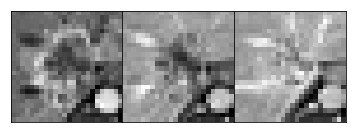

In [641]:
hf.draw_slices(x_test_quick[0])

t=time.time()
#state_indices = [state_ix for state_ix in range(num_states) if z_states_bool[state_ix][f_ix]]
#p_z_x does not need to be rescaled because the factor cancels out
var_adj = np.zeros([num_states])
a_i = np.zeros([num_states])
c_i = np.zeros([num_states])

for u_ix in range(num_units):
    for state_ix in range(num_states):
        mean = np.dot(mu[:, u_ix], z_states[state_ix]) + m[u_ix]
        a_i[state_ix] = sum([p_z_x[img_ix, state_ix] * (filter_results[img_ix, u_ix] - mean)**2 for img_ix in range(num_imgs)])
        c_i[state_ix] = sum(p_z_x[:, state_ix])

    temp = scipy.optimize.linearmixing(\
                lambda Var: sum([a_i[state_ix]/(sum(np.where(z_states[state_ix]==1, Var[:-1]**2, 0))+Var[-1]**2)**2 - \
                 c_i[state_ix]/(sum(np.where(z_states[state_ix]==1, Var[:-1]**2, 0))+Var[-1]**2) for state_ix in range(num_states)]), \
                  np.concatenate([sigma[:, u_ix], [s[u_ix]]]), verbose=True, maxiter=10000)
    
    #sigma_est[:, u_ix]
    if u_ix % 20 == 0:
        print(u_ix, time.time()-t)
    break

t=time.time()
for f_ix in range(num_features):
    state_indices = [state_ix for state_ix in range(num_states) if z_states_bool[state_ix][f_ix]]
    #p_z_x does not need to be rescaled because the factor cancels out
    var_adj = np.zeros([num_states])
    a_i = np.zeros([num_states])
    c_i = np.zeros([num_states])
    
    for u_ix in range(num_units):
        for state_ix in state_indices:
            z = z_states[state_ix]

            mean = np.dot(mu[:, u_ix], z) + m[u_ix]
            var_adj[state_ix] = sum(np.where(z==1, sigma[:, u_ix]**2, 0)) + s[u_ix]**2 - sigma[f_ix, u_ix]**2
            
            a_i[state_ix] = sum([p_z_x[img_ix, state_ix] * (filter_results[img_ix, u_ix] - mean)**2 for img_ix in range(num_imgs)])
            c_i[state_ix] = sum(p_z_x[:, state_ix])
        
        sigma_est[f_ix, u_ix] = sqrt(scipy.optimize.fsolve(lambda x: sum([a_i[state_ix]/(x+var_adj[state_ix])**2 - \
                                         c_i[state_ix]/(x+var_adj[state_ix]) for state_ix in state_indices]), \
                                          sigma[f_ix, u_ix]))
        
        if u_ix % 20 == 0:
            print(f_ix, u_ix, time.time()-t)

header = ['filter_num']
for cls in C.classes_to_include:
    header += [f+"_"+cls for f in features_by_cls[cls]]

with open('E:\\feature_filters.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(header)
    for f_num in range(100):
        writer.writerow([f_num] + [feature_filters[f][f_num] for cls in features for f in features_by_cls[cls]])

In [98]:
Z_test_features = ['E106097391_0', 'E104978772_1', '12900535_0', 'E100150242_0', 'E105490014_0', 'E103147618_0', 'E103510187_0', 'E104657225_0', 'E100551966_0', 'E101388602_0', 'E100215900_8', 'E100215900_7', 'E104045692_0', '13104521_0', 'E100383453_0', '12943286_0', '12271995_0', 'E102315724_0', 'E104949189_0', 'E100511083_1', 'E101579471_0', '13018986_1', '13203550_8', '13112385_0', '12712463_0', '12361082_0', '13028374_0', 'E103985934_1', 'E100529980_0', '12042703_3', '12961059_0', 'E105724706_2', 'E100592424_2', 'E103104254_0', 'E104546069_0', 'E101665217_1', '12090000_0', 'E100592424_1', '12961059_1', 'E105474285_0', '12502068_1', 'E100814791_0', 'E102613189_0', 'E105427046_0', 'E102881031_1', 'E102929168_0', 'E102310482_0', 'E102095465_0', 'E101811299_0', 'E104737273_0', '12890053_0', 'E100168661_1', '12637865_0', 'E100168661_2', '12239783_0', '12707781_0', '12706568_1', '12823036_0', '12404081_0', '12365693_1']

x_test = {cls: orig_data_dict[cls][0][np.where(np.isin(orig_data_dict[cls][1], Z_test_features))] for cls in C.classes_to_include}
Z_test = {cls: orig_data_dict[cls][1][np.where(np.isin(orig_data_dict[cls][1], Z_test_features))] for cls in C.classes_to_include}

In [ ]:
# Least squares approach
Theta = np.array([feature_filter_means[f] for f in all_features])
Theta = np.transpose(Theta, (1,0))

filters_test = {}
features_test = {}
for cls in C.classes_to_include:
    filters_test[cls] = model_dense_outputs.predict(x_test[cls], verbose=False)
    filters_test[cls] = (filters_test[cls] - filter_avgs) / filter_stds
    features_test[cls] = np.linalg.lstsq(Theta, np.transpose(filters_test[cls], (1,0)))[0]
    #filters_test[cls] = np.apply_along_axis(lambda x: x / filter_avgs, 1, filters_test[cls])

In [33]:
from sklearn.decomposition import FactorAnalysis

In [99]:
fa = FactorAnalysis(10)

In [36]:
filter_results.shape

(637, 100)

In [89]:
from numpy import matmul, diag

In [87]:
def covar_to_corr(covar):
    A = np.diag(np.diag(covar)**(-0.5))
    return np.matmul(np.matmul(A, covar), A)

In [90]:
corr = covar_to_corr(dummy_fa.get_covariance())

In [ ]:
np.linalg.eigvals(corr - np.linalg.pinv(np.diag(np.diag(np.linalg.pinv(corr)))))

In [ ]:
def get_cutoff_eigenval()

In [65]:
dummy = np.random.normal(size=filter_results.shape)
dummy_fa = FactorAnalysis()
dummy_fa.fit(dummy)

FactorAnalysis(copy=True, iterated_power=3, max_iter=1000, n_components=None,
        noise_variance_init=None, random_state=0, svd_method='randomized',
        tol=0.01)

In [ ]:
np.linalg.eigvals(dummy_fa.get_covariance())

In [101]:
sum(np.linalg.eigvals(fa.get_covariance()) > np.mean(np.linalg.eigvals(dummy_fa.get_covariance())))

8

In [100]:
fa.fit(filter_results)

FactorAnalysis(copy=True, iterated_power=3, max_iter=1000, n_components=10,
        noise_variance_init=None, random_state=0, svd_method='randomized',
        tol=0.01)

In [ ]:
np.linalg.eigvals()

In [53]:
x=3
fa.get_covariance()[x,x] - fa.noise_variance_[x]

0.89081373261106078

cls = "colorectal"
x_test_quick = orig_data_dict[cls][0][np.where(orig_data_dict[cls][1] == "E105724706_2.npy")]
x_test_quick = orig_data_dict["fnh"][0][np.where(orig_data_dict["fnh"][1] == "E104189184_0.npy")]
filters_quick = model_dense_outputs.predict(x_test_quick, verbose=False)

In [ ]:
img_num = 0
evidence = {}

for f in all_features:
    evidence[f + "/" + str(cls_features[f])] = cnna.get_evidence_strength(feature_filters[f], filters_quick[0])#filters_test[true_cls][img_num])
    #max_strength = max(max_strength, evidence[f + "/" + str(cls_features[f])])

#for f in evidence:
#    evidence[f] /= max_strength
print("Detected features:")
for f,strength in sorted(evidence.items(), key=lambda x:x[1], reverse=True)[:5]:
    #if strength > 1:
    print("- " + f, "- %d%%" % (strength*100))

hf.plot_section_auto(x_test_quick[0])#[true_cls][img_num])

In [101]:
output = {}
for cls in C.classes_to_include:
    for img_num in range(len(filters_test[cls])):
        z = Z_test[cls][img_num]
        x = np.expand_dims(x_test[cls][img_num], axis=0)
        evidence = {}
        
        output[z] = [cls]
        
        preds = model.predict(x, verbose=False)[0]
        for pred_cls, pred_conf in sorted(zip(C.classes_to_include, preds), key=lambda x:x[1], reverse=True)[:2]:
            output[z] = output[z] + [pred_cls]
        
        #for f in all_features:
        #    evidence[f + "/" + str(cls_features[f])] = get_evidence_strength(feature_filters[f], filters_test[cls][img_num])
        
        for i in range(len(all_features)):
            evidence[all_features[i] + "/" + str(cls_features[all_features[i]])] = features_test[cls][i, img_num]
        
        f1='infiltrative'
        f2='lobulated margins'
        if evidence[f1 + "/" + str(cls_features[f1])] < evidence[f2 + "/" + str(cls_features[f2])]:
            evidence.pop(f1 + "/" + str(cls_features[f1]))
        else:
            evidence.pop(f2 + "/" + str(cls_features[f2]))
        
        for f,strength in sorted(evidence.items(), key=lambda x:x[1], reverse=True):
            output[z] = output[z] + [f, strength]

In [104]:
with open('E:\\filters_pred5.csv', 'w', newline='') as csvfile:
    header = ['img_fn', 'agreement1', 'agreement2', 'true_cls', 'pred_cls1', 'pred_cls2'] + \
            [s for i in range(len(all_features)) for s in ['feature_%d' % i,'strength_%d' % i]]
    writer = csv.writer(csvfile)
    writer.writerow(header)
    for z_num in range(len(Z_test_features)):
        writer.writerow([Z_test_features[z_num]] + [output[Z_test_features[z_num]][0] in output[Z_test_features[z_num]][3], \
                        output[Z_test_features[z_num]][0] in output[Z_test_features[z_num]][5]] + output[Z_test_features[z_num]])

In [60]:
df = pd.read_excel("E:\\filters_pred3.xlsx")

In [75]:
agree = 0
for _,row in df.iterrows():
    if row["pred_cls1"] in row["feature_1"]:
        agree += 1
print(agree/60)

52
